# Grupo 07 - Marcos Rafael Núñez & Alejandro Daniel Díaz Román

## Información de la práctica:

   #### · Primero están definidas las funciones usadas con los respectivos comentarios de la taera que realizan
   #### · Después está la ejecución y la representación de los resultados
   #### · Finalmente las conclusiones de la parte a) y la parte b)

PD: Junto con cada definición de las funciones viene un ejemplo de llamada a dicha función

In [1]:
#Todos los Imports necesarios

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt 

In [2]:
def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = np.ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

### Parámetros globales
    Para modificar poder probar los diferentes parámetros del programa, hacerlo desde aquí es lo adecuado

In [262]:
seed = 2020

numMuestras = 3

#Niveles de exhaustividad a calcular
niveles = [3, 10]

Carga de los datos que se utilizarán:

In [4]:
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test')

print("Training texts:", len(train_data.data))
print("Test texts:", len(test_data.data))

Training texts: 11314
Test texts: 7532


In [38]:
train_data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
# Pasamos el fichero a una lista (una línea por item)
with open('words.txt') as f:
    dictionary = f.read().splitlines()

La bolsa de palabras que usaremos, y la modificación de la parte b) con el TF/IDF

In [6]:
vectorizer = CountVectorizer(binary= False, vocabulary=dictionary, stop_words='english', ngram_range = (1,1))

trainVectorData = vectorizer.fit_transform(train_data.data)
testVectorData = vectorizer.fit_transform(test_data.data)

tfidfer = TfidfTransformer()
trainTF = tfidfer.fit_transform(trainVectorData)

In [7]:
feature_names = vectorizer.get_feature_names()

In [8]:
write_terms(feature_names, test_data.data, trainVectorData, 154)

Mensaje 154 : From: giza@HQ.Ileaf.COM (Jim Giza x6453)
Subject: House for sale in Sandwich, Ma
Nntp-Posting-Host: cheops
Reply-To: giza@HQ.Ileaf.COM (Jim Giza x6453)
Organization: Interleaf, Inc.
Distribution: usa
Lines: 18

For sale by owners who were also the builders

Contemporary Cape House located in Sandwich, Ma

Three bedrooms, two baths, one car oversized garage
large eat-in kitchen
Cathedral ceiling from to back living room
deck off of kitchen and dining room

20,000 sq ft
1,696 sq ft living space
full walk-out basement

$139,900, creative financing a possibility

contact Peg Moore @ (508) 771-0320 or Ron Nordstrom @ (508) 394-9652



Mensaje 154 vectorizado: ['built' 'coming' 'company' 'compatible' 'complaints' 'components'
 'computer' 'connecting' 'current' 'dept' 'dock' 'docking' 'docks' 'does'
 'duo' 'excuse' 'facts' 'functions' 'got' 'guess' 'hearing' 'imagine'
 'including' 'info' 'interesting' 'internet' 'know' 'like' 'lines' 'macs'
 'models' 'obsoleting' 'ooh' 'organiza

### Selección aleatoria de muestras

Funciones para la selección aleatoria de los mensajes que se utilizarán parala recuperación de los mensajes del grupo de entrenamiento.

 - reshape2D: Función auxiliar para reordenar las dimensiones para tener la representación que deseamos de la información
 
 - selecIndexes: Función para seleccionar los índices. Es totalmente aleatorio y acepta una semilla para poder reproducir resultados previos. La cantidad de resultados que devilverá será de la forma de un array de N * M, siendo N la cantidad de clases y M el número de muestras seleccionadas (por defecto 3)
 

In [9]:
#cambia la forma de un array a otro de 2 dimensiones
def reshape2D(array, filas, columnas):
    
    nuevaForma = np.reshape(array, [filas,columnas])
    return nuevaForma

In [10]:
#while the last element of the sum of all the previous elements (which is the sum of the total selectec texts) 
#    is less than the desired amount, it will keep choosing candidates

def selectIndexes(num, clases, seed=2021):

    random.seed(seed)
    
    selected = np.zeros(len(clases))
    selected_index = np.zeros(len(test_data.target_names)*num)
        
    while (np.cumsum(selected)[-1] < len(selected)*num):

        #Indice aleatorio de la lista de mensajes
        index = random.randint(0, len(test_data.target) - 1)
        #cat = numero de la categoria a la que pertenece el índice elegido
        cat = test_data.target[index]
        #Comprobamos que no haya ya 3 elementos de la categoría a la que pertenezca el index y lo añadimos a la cuenta y a la lista de índices
        #La lista de índices estará ordenada por categorías
        if(selected[cat] < num):
            index_pos = int(cat*num + selected[cat])
            selected_index[index_pos] = index
            selected[cat] += 1
    nuevaForma = reshape2D(selected_index, len(clases), num)
    return nuevaForma

In [11]:
ind = selectIndexes(numMuestras, test_data.target_names)

Hacer un ejemplo de cosine similaroty

### Cálculo de la distancia de coseno (cosine_similarity)

En este caso también contamos con dos funciones:

  - sortSimilarityIndex: Función auxiliar que dado el cálculo del cosine_similarity, devolverá un array en el cual están los índices de los elementos ordenados. Es decir, que en la primera posición está el índice del elemento que mayor valor ha devuelto el cosine_similarity, esto nos permite no perder la información de a que clase pertenecía ese texto, ya que no hemos cambiado el orden, símplemente tenemos su índice. Esto lo conseguimos gracias a la función 'argsort' de numpy. Debajo de los funciones hay un ejemplo por si la explicación no ha sido lo suficientemente explicativa
  
  - cosSim_calc: Función que toma los índices seleccionados reviamente y los vectores de test y de train para calcular el cosine_similarity de las muestras seleccionadas

In [12]:
def sortSimilarityIndex(Simi):
    
    for i, category in enumerate(Simi):
        for j, sim in enumerate(category):
            Simi[i][j] = np.argsort(-sim)
    return Simi

In [13]:
def cosSim_calc(indexes, test_vector, train_vector):
    cosSim = np.zeros(indexes.shape, object)
    for i, indexList in enumerate(indexes):
        for j, index in enumerate(indexList):
            cosSim[i][j] = cosine_similarity(test_vector[index], train_vector)[0]
    return cosSim

In [14]:
cos_sim = cosSim_calc(ind, testVectorData, trainVectorData)
cos = sortSimilarityIndex(cos_sim)

Como vemos 'cos' contiene los resultados, es un array de 20 elementos (uno por cada clase) y cada elemento contiene 3 arrays, uno por cada muestra seleccionada, dichos arrays contienen los índices de los mejores elementos.

In [15]:
print(cos.shape)
print(cos)

(20, 10)
[[array([4422, 8484, 7278, ...,  144, 1541, 9412], dtype=int64)
  array([2416, 5535, 1074, ...,  144, 1541, 9412], dtype=int64)
  array([8095, 5568, 6663, ...,  144, 1541, 9412], dtype=int64)
  array([5200, 7100,  713, ...,  144, 1541, 9412], dtype=int64)
  array([8362, 9185, 7673, ..., 7630,  144, 9412], dtype=int64)
  array([9210, 9224,  335, ..., 3629, 7910, 8519], dtype=int64)
  array([1439,   12, 8282, ...,  144, 1541, 9412], dtype=int64)
  array([8754, 5244, 2698, ...,  144, 1541, 9412], dtype=int64)
  array([ 3355,  1967, 10947, ...,   144,  9412,  8519], dtype=int64)
  array([4304, 3987, 5012, ..., 4582, 1541, 9412], dtype=int64)]
 [array([ 3794, 10826,  3603, ...,   144,  1541,  9412], dtype=int64)
  array([3444, 3976, 7696, ..., 4582, 5603, 9412], dtype=int64)
  array([ 6057, 10714,    12, ...,   491,  1541,  9412], dtype=int64)
  array([4317, 8144, 3514, ...,  144, 1541, 9412], dtype=int64)
  array([9998, 4155, 8494, ..., 1541, 9412, 8519], dtype=int64)
  array([ 73

### Ejemplo seleccionando dos terminos

En este caso observamos que el texto que más se ha parecido a la muestra de índice 5228 (del test) es el texto con índice 4422 (del train)

In [16]:
int(ind[0][0])

5228

In [17]:
cos[0][0]

array([4422, 8484, 7278, ...,  144, 1541, 9412], dtype=int64)

In [39]:
train_data.target_names[train_data.target[5228]]

'misc.forsale'

In [40]:
train_data.target_names[train_data.target[4422]]

'talk.politics.guns'

In [34]:
cosine_similarity(testVectorData[5228], trainVectorData)[0][4422]

0.3015113445777636

Aunque los textos pertenezcan a distintas clases 'misc.forsale' y 'talk.politics.guns' el cosine_similarity ha determinado que ese texto de la categoría de arams sea el que más se parece a al texto de la categoría de for sale. Abajo podemos ver los textos y la vectorización de los mismos, como podemos observer tienen poco en común pero como en la vectorización hay unas pocas palabras que coinciden, obtiene una alta puntuación.

Más adelante veremos cómo afecta esto a distintas categorías

In [19]:
write_terms(feature_names, test_data.data, testVectorData, 5228)

Mensaje 5228 : From:  (Rashid)
Subject: Re: Yet more Rushdie [Re: ISLAMIC LAW]
Nntp-Posting-Host: nstlm66
Organization: NH
Lines: 19

In article <116171@bu.edu>, jaeger@buphy.bu.edu (Gregg Jaeger) wrote:
> 
I have already made the clear claim that
> Khomeini advocates views which are in contradition with the Qur'an
> and have given my arguments for this. This is something that can be
> checked by anyone sufficiently interested. Khomeini, being dead,
> really can't respond, but another poster who supports Khomeini has
> responded with what is clearly obfuscationist sophistry. This should
> be quite clear to atheists as they are less susceptible to religionist
> modes of obfuscationism. 
> 

Don't mind my saying this but the best example of obfuscation is to
condemn without having even your most basic facts straight. If you
want some examples, go back and look at your previous posts, where
you manage to get your facts wrong about the fatwa and Khomeini's 
supposed infallibility.

As sala

In [21]:
write_terms(feature_names, train_data.data, trainVectorData, 4422)

Mensaje 4422 : From: dduff@col.hp.com (Dave Duff)
Subject: Re: ATF BURNS DIVIDIAN RANCH! NO SURVIVORS!!!
Organization: HP Colorado Springs Division
Lines: 1
NNTP-Posting-Host: fajita19.cs.itc.hp.com

NUT CASE PANICS!!!!JUMPS THE GUN ON THE NET BEFORE GETTING FACTS STRAIGHT!!!!

Mensaje 4422 vectorizado: ['facts' 'getting' 'jumps' 'lines' 'organization' 'panics' 'posting'
 'ranch' 'straight' 'subject' 'survivors'] 



### Cálculo de los niveles de exhaustividad

Ahora, como ya tenemos los índices de los mejores resultados del cosine_similarity tenemos símplemente que coger los N primeros elementos, siendo N el nivel de exhaustividad

In [113]:
def nivelesExhaustividad(data, niv):
    #exhaustN = np.zeros(data.shape, object)
    exhaust = []
    
    for nivel in niv:
        exhaustN = np.zeros(data.shape, object)
        for i, indexList in enumerate(data):
            for j, index in enumerate(indexList):
                exhaustN[i][j] = data[i][j][:nivel]
        exhaust.append(exhaustN)
        
        exhaustNP = np.array(exhaust)
        
    return exhaustNP

In [114]:
exhaustIndex = nivelesExhaustividad(cos, niveles)

### Cálculo de la precisión de los resultados y la precisión media

Para calcular la precisión usaremos los elementos recuperados por el nivel de exhaustividad y los compararemos con la clase a la que realmente pertenecen

In [25]:
def calcPrecision(exhaustIndex, train_data):
    precision = np.zeros(exhaustIndex.shape, object)
    
    for i, nivel in enumerate(exhaustIndex):
        for j, indexList in enumerate(nivel):
            for k, BestIndexes in enumerate(indexList):
                prec = 0
                for index in BestIndexes:
                    #Si el indice del train data coincide con la j, es bueno
                    if(train_data[index] == j):
                        prec += 1
                prec /= len(BestIndexes)
                
                precision[i][j][k] = prec
                
    return precision

In [26]:
precision = calcPrecision(exhaustIndex, train_data.target)

La precMedia nos calcualrá la media de cada clase por cada nivel de exhaustividad

In [27]:
def precMedia(precisiones):
    precMedia = np.zeros(precisiones.shape, object)
    # Ahora reducimos una dimansión, porque al hacer la media los "num_samples" de valores se reducirán a solo 1
    precMedia = precMedia[:, :, 0]

    for i, nivel in enumerate(precisiones):
        for j, clase in enumerate(nivel):
            precMedia[i][j] = clase.mean()
            
    return precMedia

In [28]:
preciMedia = precMedia(precision)

### Representación de información

imprimirGraficas es una función útil para representar símplemente los resultados de una sola bolsa de palabras, para comparar los resultados de la bolsa de palabras normal con el TF/IDF, está más abajo

In [46]:
def imprimirGraficas(info, niveles, clases):
    fig, ax = plt.subplots()
        
    ax.set_xticks(np.arange(len(clases)))
    ax.set_xticklabels(clases)

    ylabel = np.arange(0.0, 1.0, 0.1)
    ax.set_yticks(ylabel)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    ax.set_title("Precisión media con diferentes niveles de exhaustividad")
    fig.set_size_inches(14,8)
    fig.tight_layout()
    
    for i, nivel in enumerate(info):
        ax.plot(clases, nivel, dashes=[5, 5], label = "Nivel exhaustividad " + str(niveles[i]))
    
    plt.legend(framealpha=1, frameon=True);
    
    plt.show()

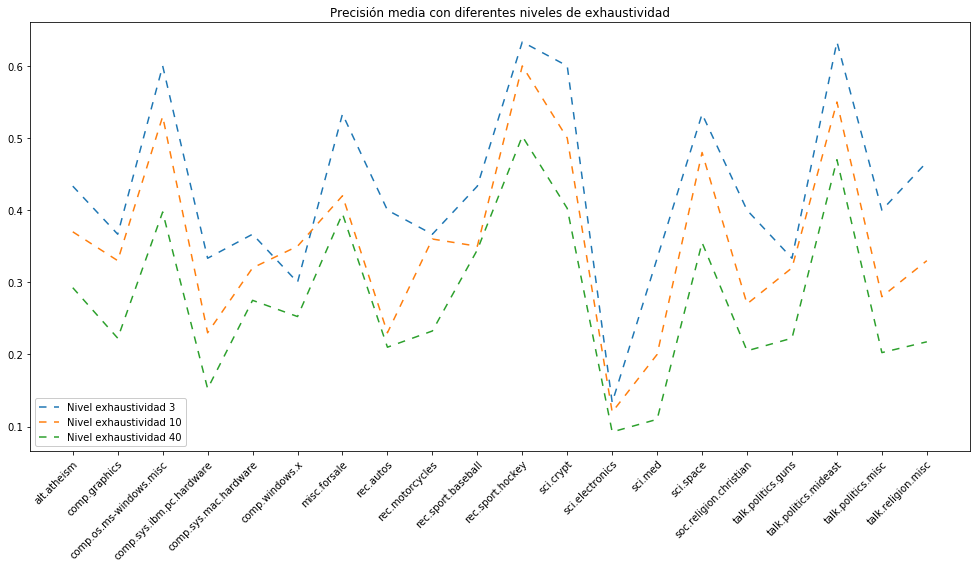

In [47]:
imprimirGraficas(preciMedia, niveles, train_data.target_names)

allInOne resume todo el proceso previo a esta función para que sea más fácil probarlo entero

In [31]:
def allInOne(trainVecData, testVecData, s=2020):
    
    indices = selectIndexes(numMuestras, test_data.target_names, s)
    
    cosineSimilarity = cosSim_calc(indices,testVecData, trainVecData)
    cosine = sortSimilarityIndex(cosineSimilarity)
    
    
    exhaustividadIndex = nivelesExhaustividad(cosine, niveles)
    
    precisionClases = calcPrecision(exhaustividadIndex, train_data.target)
    
    precisionMedia = precMedia(precisionClases)
    
    imprimirGraficas(precisionMedia, niveles, train_data.target_names)

A continuación enseñamos un par de ejemplos de la ejecución con distintas semillas

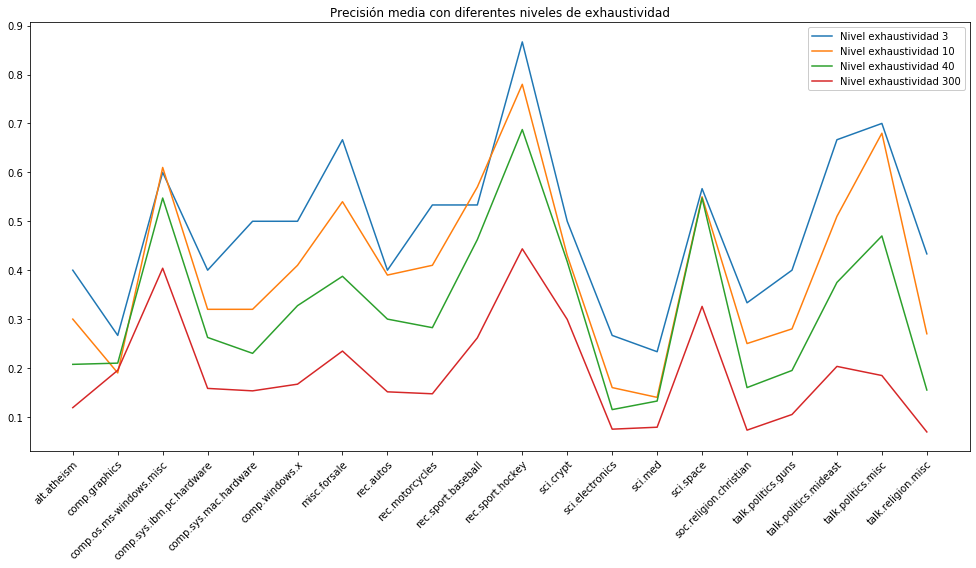

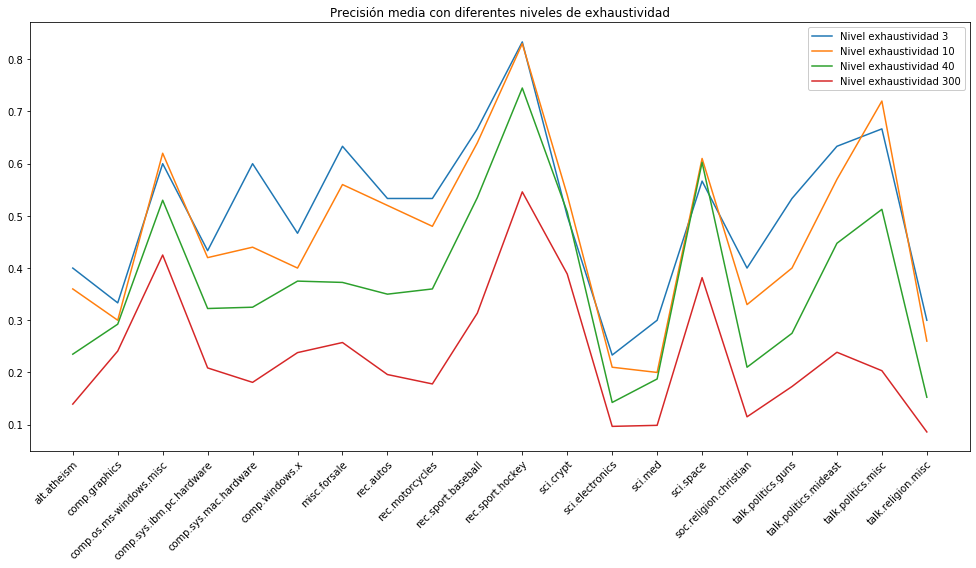

In [43]:
allInOne(trainVectorData, testVectorData, 5)
allInOne(trainTF, testVectorData, 5)

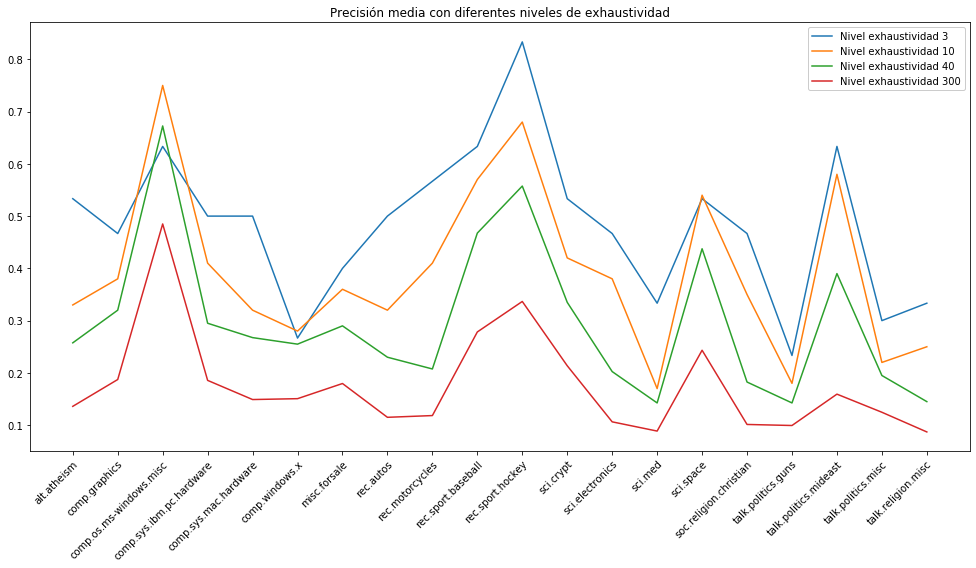

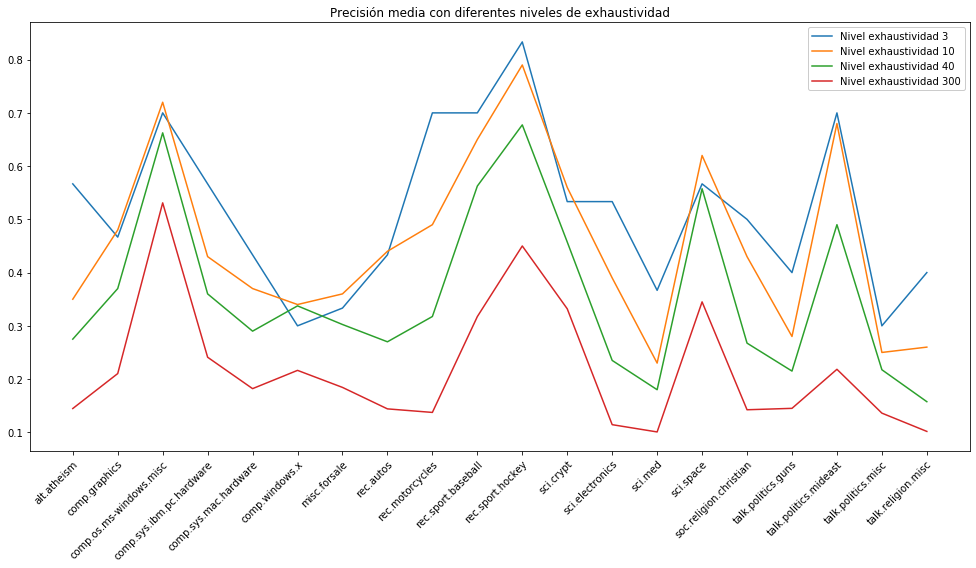

In [42]:
allInOne(trainVectorData, testVectorData, 6)
allInOne(trainTF, testVectorData, 6)

Esta es una función auxiliar que realiza toda la ejecución pero no imprime la gráfica, símplemente devuelve el array con las precisiones medias

In [50]:
def allHastaPrecMedia(trainVecData, testVecData, s=2020):
    
    indices = selectIndexes(numMuestras, test_data.target_names, s)
    
    cosineSimilarity = cosSim_calc(indices,testVecData, trainVecData)
    cosine = sortSimilarityIndex(cosineSimilarity)
    
    
    exhaustividadIndex = nivelesExhaustividad(cosine, niveles)
    
    precisionClases = calcPrecision(exhaustividadIndex, train_data.target)
    
    precisionMedia = precMedia(precisionClases)
    
    return precisionMedia

dosGraficas combinará dos resultados de precisiones medias que le pasemos. Lo usaremos para combinar en una sola gráfica los resultados de la ejecución normal con los del TF/IDF y poder compararlos mejor

In [54]:
def dosGraficas(info1, info2, niveles, clases):
    
    fig, ax = plt.subplots()
        
    ax.set_xticks(np.arange(len(clases)))
    ax.set_xticklabels(clases)

    ylabel = np.arange(0.0, 1.0, 0.1)
    ax.set_yticks(ylabel)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    ax.set_title("Precisión media con diferentes niveles de exhaustividad")
    fig.set_size_inches(14,8)
    fig.tight_layout()
    
    for i, nivel1 in enumerate(info1):
        ax.plot(clases, nivel1, dashes=[5, 5], label = "Nivel exhaustividad " + str(niveles[i]))
        
    for j, nivel2 in enumerate(info2):
        ax.plot(clases, nivel2, label = "TF/IDF Nivel exhaustividad " + str(niveles[j]))
    
    plt.legend(framealpha=1, frameon=True);
    
    plt.show()

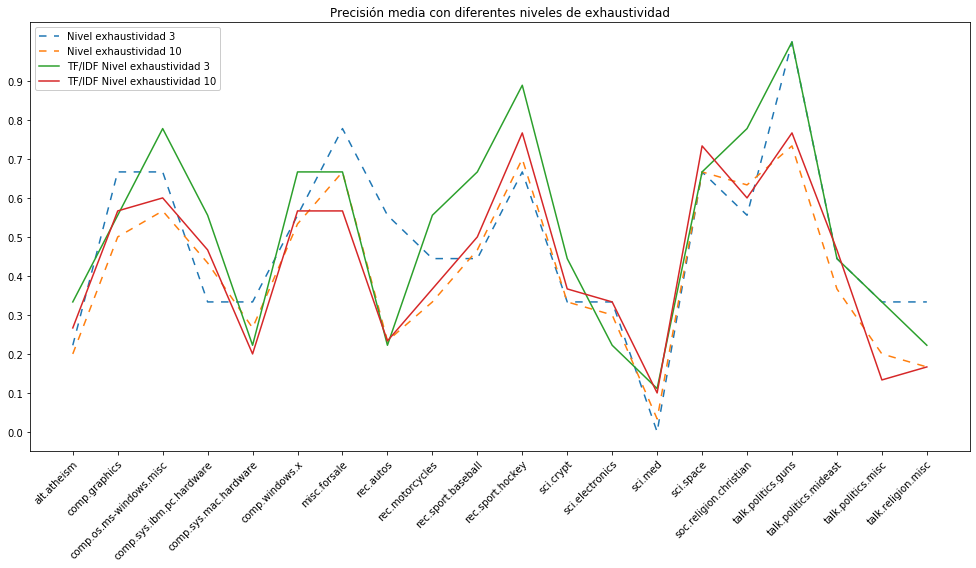

In [59]:
precisionMediaMala = allHastaPrecMedia(trainVectorData, testVectorData, seed)
precisionMediaTF = allHastaPrecMedia(trainTF, testVectorData, seed)

dosGraficas(precisionMediaMala, precisionMediaTF, niveles, train_data.target_names)

In [98]:
datasetMalo = pd.DataFrame(list(zip(precisionMediaMala[0], precisionMediaMala[1])), columns =['3', '10'])

In [100]:
datasetMalo.describe()

,3,10
count,20.000000,20.000000
mean,0.483333,0.416667
std,0.223025,0.203622
min,0.000000,0.033333
25%,0.333333,0.258333
50%,0.444444,0.400000
75%,0.666667,0.583333
max,1.000000,0.733333


In [101]:
datasetTF = pd.DataFrame(list(zip(precisionMediaTF[0], precisionMediaTF[1])), columns =['3', '10'])

In [103]:
datasetTF.describe()

,3,10
count,20.000000,20.000000
mean,0.516667,0.438333
std,0.250471,0.210339
min,0.111111,0.100000
25%,0.305556,0.258333
50%,0.555556,0.466667
75%,0.666667,0.575000
max,1.000000,0.766667


# Apartado a)

Mostremos ahora unas pocas ejecuciones de recuperación con una bolsa de palabras no binaria y un rango de n-gramas de (1,1)

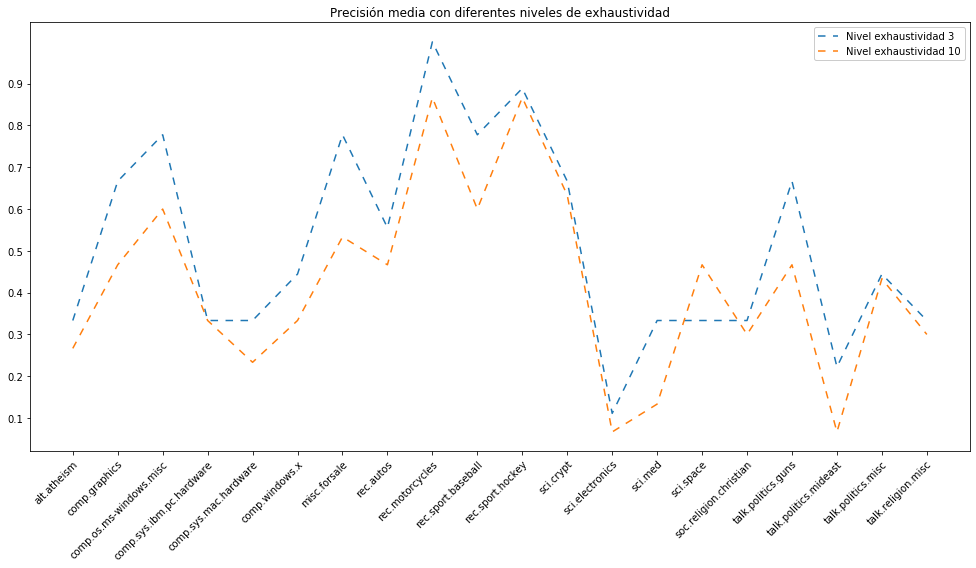

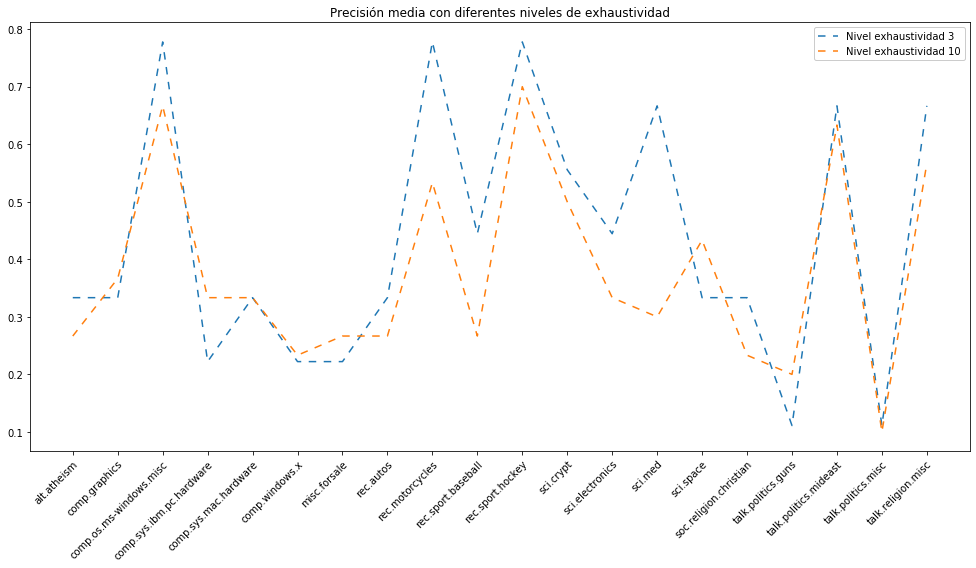

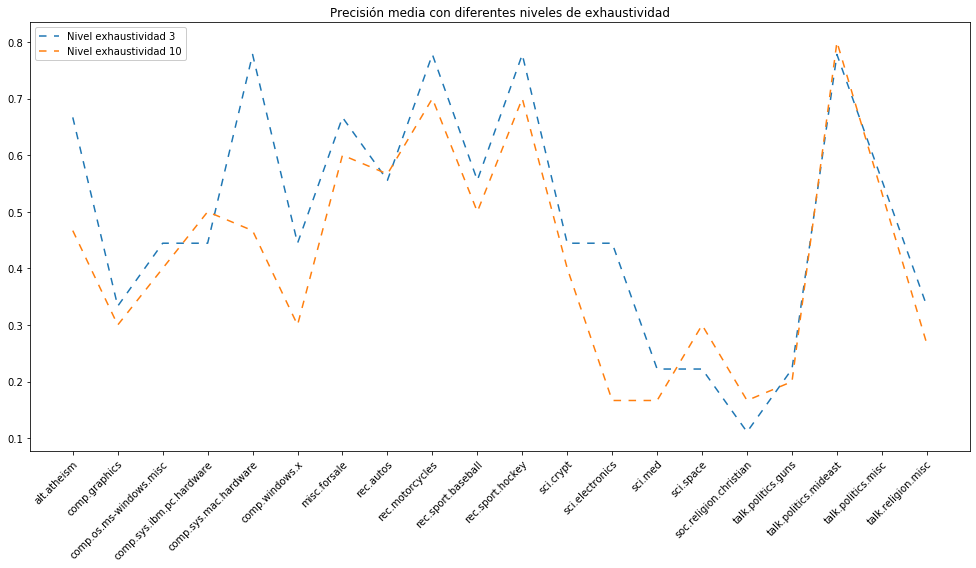

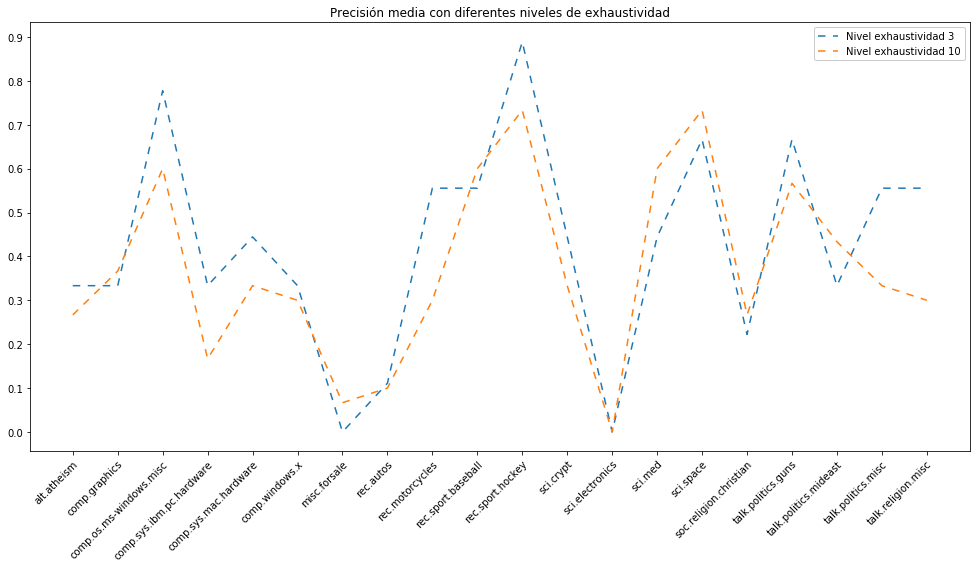

In [127]:
allInOne(trainVectorData, testVectorData, 314)
allInOne(trainVectorData, testVectorData, 31415)
allInOne(trainVectorData, testVectorData, 3141592)
allInOne(trainVectorData, testVectorData, 314159265)

Como podemos ver la clase 'sci.electronics' es de las que peores resultados obtiene, junto con otras como 'soc.religion.christian', 'sci.med' o 'comp.sys.mac.hardware'.

A priori estas clases que han obtenido malos resultados puede que sea debido a que no tienen palabras que las diferencien claramente de otras clases, por ejemplo en 'electronics' es fácil que se hablan de temas similares a los que se hable en 'mac' o 'PC' por lo que será complicado discernir entre estos temas. Sin embargo temas como hockey o la política de 'mideast' es bastante posible que tengas términos que los diferencien claramente y por ellos obtengan buenos resultados consistentemente

Ahora nos centraremos en analizar la clase'sci.electronics' ya que parece que es de las que peores resultados obtiene en repetidas pruebas.

Realizaremos una nueva ejecución:

In [135]:
train_data.target_names.index('sci.electronics')

12

In [164]:
elecIndices = selectIndexes(numMuestras, test_data.target_names, 314)

In [169]:
elecIndices[12]

array([3287., 1701., 3326.])

In [170]:
muestra1 = cosine_similarity(testVectorData[elecIndices[12][0]], trainVectorData)[0]
muestra2 = cosine_similarity(testVectorData[elecIndices[12][1]], trainVectorData)[0]
muestra3 = cosine_similarity(testVectorData[elecIndices[12][2]], trainVectorData)[0]

muestra1Ord = np.argsort(-muestra1)
muestra2Ord = np.argsort(-muestra2)
muestra3Ord = np.argsort(-muestra3)

In [171]:
muestra1Ord

array([2332, 8484, 2029, ..., 9412,  750, 1554], dtype=int64)

En 'muestra1Ord' tenemos a los mejores índices del entrenamiento, procedemos a visualizar los X mejores

Primero enseñamos el mensaje de muestra seleccionado

In [172]:
write_terms(feature_names, None, vector_data = testVectorData, index = elecIndices[12][0])

Mensaje 3287.0 vectorizado: ['added' 'addressing' 'ago' 'appears' 'correction' 'extra' 'hour' 'lines'
 'organization' 'posting' 'previous' 'question' 'replace' 'reply'
 'subject'] 



A continuación los 7 mejores emparejados con este

In [174]:
print("Clase: ")
print(train_data.target[muestra1Ord[0]])
write_terms(feature_names, None, vector_data = trainVectorData, index = muestra1Ord[0])

print("Clase: ")
print(train_data.target[muestra1Ord[1]])
write_terms(feature_names, None, vector_data = trainVectorData, index = muestra1Ord[1])

print("Clase: ")
print(train_data.target[muestra1Ord[2]])
write_terms(feature_names, None, vector_data = trainVectorData, index = muestra1Ord[2])

print("Clase: ")
print(train_data.target[muestra1Ord[3]])
write_terms(feature_names, None, vector_data = trainVectorData, index = muestra1Ord[3])

print("Clase: ")
print(train_data.target[muestra1Ord[4]])
write_terms(feature_names, None, vector_data = trainVectorData, index = muestra1Ord[4])

print("Clase: ")
print(train_data.target[muestra1Ord[5]])
write_terms(feature_names, None, vector_data = trainVectorData, index = muestra1Ord[5])

print("Clase: ")
print(train_data.target[muestra1Ord[6]])
write_terms(feature_names, None, vector_data = trainVectorData, index = muestra1Ord[6])

Clase: 
5
Mensaje 2332 vectorizado: ['code' 'correction' 'dialog' 'laboratory' 'lack' 'lines' 'message'
 'organization' 'posting' 'question' 'remains' 'replace' 'reply' 'rest'
 'robotics' 'sent' 'subject' 'widget'] 

Clase: 
6
Mensaje 8484 vectorizado: ['article' 'distribution' 'lines' 'organization' 'posting' 'subject'] 

Clase: 
9
Mensaje 2029 vectorizado: ['lines' 'node' 'organization' 'posting' 'stadium' 'subject'] 

Clase: 
10
Mensaje 3162 vectorizado: ['institute' 'islanders' 'isles' 'lines' 'need' 'organization'
 'polytechnic' 'posting' 'reply' 'subject'] 

Clase: 
4
Mensaje 8545 vectorizado: ['art' 'article' 'ee' 'lines' 'organization' 'question' 'subject'] 

Clase: 
4
Mensaje 3140 vectorizado: ['buy' 'lines' 'macs' 'organization' 'posting' 'subject' 'suck'] 

Clase: 
1
Mensaje 7158 vectorizado: ['lines' 'question' 'real' 'reply' 'subject' 'try' 'trident' 'works'] 



In [181]:
print(train_data.target_names[5])
print(train_data.target_names[6])
print(train_data.target_names[9])
print(train_data.target_names[10])
print(train_data.target_names[4])
print(train_data.target_names[1])

comp.windows.x
misc.forsale
rec.sport.baseball
rec.sport.hockey
comp.sys.mac.hardware
comp.graphics


Observamos que la clase 'sci.electronic' es habitualmente confundida por otros mensajes de temas relacionados con la electrónica como windows, mac o graphics. Hay algunos outliers como baseball o hocket, pero probablemente sea porque esos textos de deportes no tenían o tenían pocas palabras diferenciadoras de su clase

Como hemos comentado previamente no tenemos ningún término muy característico que diferencia a electronics de temas similares.

Si fuera la única clase que tuviera que ver con el tema de electrónica entre muchos mensajes de deportes, por ejemplo. Es bastante seguro que obtendría muy buenos resultados catalogando otros textos de electrónica

# Apartado b)

recuperemos la gráfica previamente vista que comparaba los resultados con y sin TF/IDF

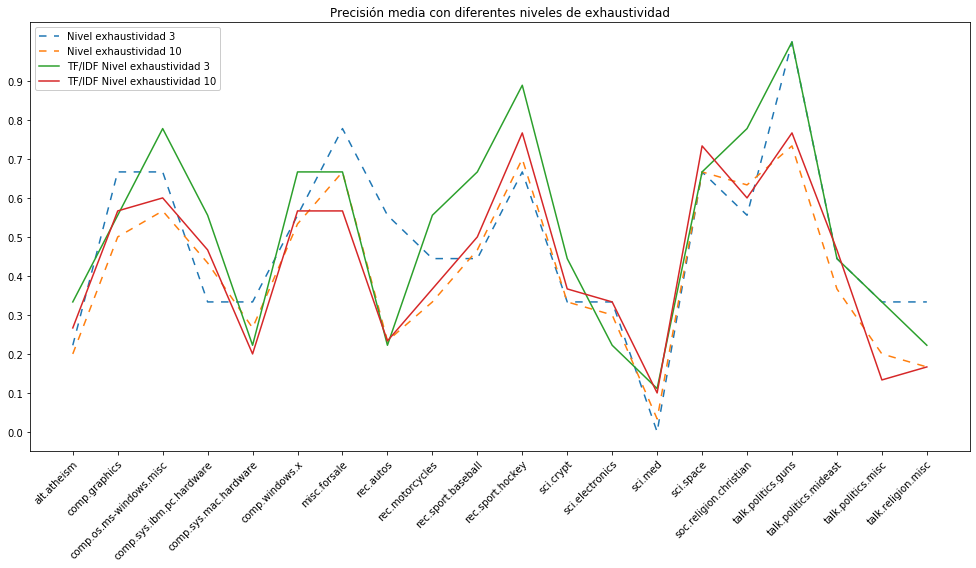

In [182]:
dosGraficas(precisionMediaMala, precisionMediaTF, niveles, train_data.target_names)

por lo general no han cambiado demasiado, salvo en clases como 'rec.autos' que para un nivel de exhaustividad 3 baja de un 60% a un 20% de precisión o en 'rec.sport.hockey' que para el nivel de exhaustividad 3 aumenta de un 70% a un 90%

Debido a que el nivel de exhaustividad 3 varía mucho más que el nivel 10, podemos suponer que al recuperar batantes menos datos es mucho más fácil que los resultados se nos disparen por algunos outliers, por eso observamos que a un nivel de exhaustividad más alto obtendremos valores, aunque menos precisos, más fiables.

Probemos ahora a introducir un nivel de exhaustividad elevado para ver si nuestra hipótesis es se cumple

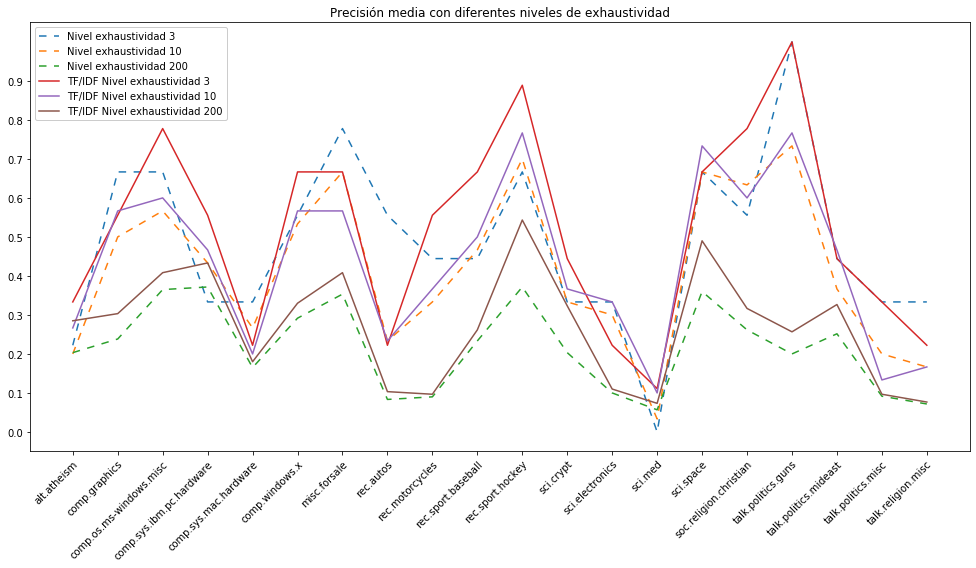

In [263]:
niveles = [3, 10, 200]

precisionMediaMala2 = allHastaPrecMedia(trainVectorData, testVectorData, seed)
precisionMediaTF2 = allHastaPrecMedia(trainTF, testVectorData, seed)

dosGraficas(precisionMediaMala2, precisionMediaTF2, niveles, train_data.target_names)

Como podemos observar a un nivel de exhaustividad de 200, la precisión, en efecto baja bastante, ya que estamos recuperando cada vez peores valores. Sin embargo, podemos comprobar como la bolsa de palabras con TF/IDF obtiene valores con el mismo patrón que sin TF/IDF, sin embargo, mejora sus resultados en todas y cada una de las claes, sobresaliendo, sobre todo en la clase 'rec.sport.hockey'.

Vemos pues que la hipótesis planteada era cierta, intentemos ver ahora los motivos por los cuales el TF/IDF ha conseguido mejorar de tal manera los resultados

In [264]:
i = selectIndexes(numMuestras, test_data.target_names, seed)
mayorMejora = i[10] # el de hockey

In [265]:
mayorMejora

array([3019.,  750., 5021.])

In [266]:
muestra1TF = cosine_similarity(testVectorData[mayorMejora[0]], trainTF)[0]
muestra2TF = cosine_similarity(testVectorData[mayorMejora[1]], trainTF)[0]
muestra3TF = cosine_similarity(testVectorData[mayorMejora[2]], trainTF)[0]

muestra1OrdTF = np.argsort(-muestra1TF)
muestra2OrdTF = np.argsort(-muestra2TF)
muestra3OrdTF = np.argsort(-muestra3TF)

Y ahora sin TF/IDF a ver que pasa

In [267]:
muestra1 = cosine_similarity(testVectorData[mayorMejora[0]], trainVectorData)[0]
muestra2 = cosine_similarity(testVectorData[mayorMejora[1]], trainVectorData)[0]
muestra3 = cosine_similarity(testVectorData[mayorMejora[2]], trainVectorData)[0]

muestra1Ord = np.argsort(-muestra1)
muestra2Ord = np.argsort(-muestra2)
muestra3Ord = np.argsort(-muestra3)

In [268]:
statsMuestra1 = pd.DataFrame(list(zip(muestra1, muestra1TF)), columns =['sinTF', 'conTF'])

In [269]:
statsMuestra1.describe()

,sinTF,conTF
count,11314.000000,11314.000000
mean,0.094639,0.024137
std,0.046718,0.025302
min,0.005614,0.001070
25%,0.063693,0.012838
50%,0.087121,0.018456
75%,0.117647,0.027657
max,0.822478,0.742494


Como podemos ver la similaridad que hemos hecho con TF/IDF consigue detectar mejor cuales son las caracteristicas que hacen que un texto sea similar a otro, ya que como podemos observar con los valores de la media o los cuartiles, los valores que se alejan mucho de los valores más altos, que son los que ha identificado con los más parecidos al texto de muestra y por tanto, probablemente pertenezcan a la misma clase

In [307]:
def precisionDeUnaMuestra(muestraSinTF, muestraConTF, nivel):

    acertados = 0

    for text in muestraSinTF[:nivel]:
        if (train_data.target[text] == 10):
            acertados += 1 

    acertadosTF = 0

    for text in muestraConTF[:nivel]:
        if (train_data.target[text] == 10):
            acertadosTF += 1 

    print("precisión sin TF/IDF" + str(acertados/len(muestra1Ord[:200])*100) + "%")
    print("precisión con TF/IDF" + str(acertadosTF/len(muestra1Ord[:200])*100) + "%")

In [309]:
precisionDeUnaMuestra(muestra1Ord, muestra1OrdTF, 200)
precisionDeUnaMuestra(muestra2Ord, muestra2OrdTF, 200)
precisionDeUnaMuestra(muestra3Ord, muestra3OrdTF, 200)

precisión sin TF/IDF27.0%
precisión con TF/IDF54.0%
precisión sin TF/IDF66.5%
precisión con TF/IDF71.5%
precisión sin TF/IDF18.0%
precisión con TF/IDF37.5%


Como podemos ver, si observamos la precisión con un nivel de exhustividad de 200 vemos que el TF/IDF en este caso de muestra ha acertado prácticamente el doble que sin aplicar TF/IDF

No en todos los casos de muestra va a ser igual de efectivo, pero la mejora es clara. Aquí el métido TF/IDF brilla en su máximo explendor, ya que es perfecto para esta aplicación.

Debido a que nos ayuda a encontrar los términos que son más relevantes en una texto, la bolsa de palabras resultantes será capaz de encontrar similitudes mucho más relevantes con otras bolsas de palabras, por ende, clasifica mucho mejor todas las categorías